In [1]:
#imports
import collections
from math import sqrt
import numpy as np
import scipy.stats as stats
import pandas as pd
import sqlite3
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [37]:
# Connect to DB and read all data
conn = sqlite3.connect('bee_sightings_native.sqlite')
bee_data = pd.read_sql('SELECT * from bee_sightings', conn)
bee_data.replace('', np.nan, inplace=True)
bee_data.head()

,bee_id,common_name,dateidentified,latitude,longitude,floral_host,sightingstatus_id,native_status
0,21041,Yellow-faced bumble bee,2017-08-05 00:00:00.000000,45.524403,-122.637095,None,1,None
1,20632,Yellow-faced bumble bee,2017-08-08 00:00:00.000000,45.494031,-122.427821,Joe Pye weed,1,Non-native
2,20423,Obscure bumble bee,2017-08-06 00:00:00.000000,45.584405,-122.723538,None,1,None
3,20263,Bumble bee,2017-08-03 00:00:00.000000,45.494263,-122.427542,Aster Douglasii,1,Native
4,19923,Bumble bee,2017-07-27 00:00:00.000000,45.539996,-122.571588,0,1,None


In [38]:
# Grab size of dataset
all_plants_by_status = bee_data[(bee_data['floral_host'].notnull())]
natives_count = len(all_plants_by_status[all_plants_by_status['native_status'] == "Native"])
print("Total number of plants: {}, Total number of natives: {}".format(len(all_plants_by_status), natives_count))

Total number of plants: 312, Total number of natives: 68


130


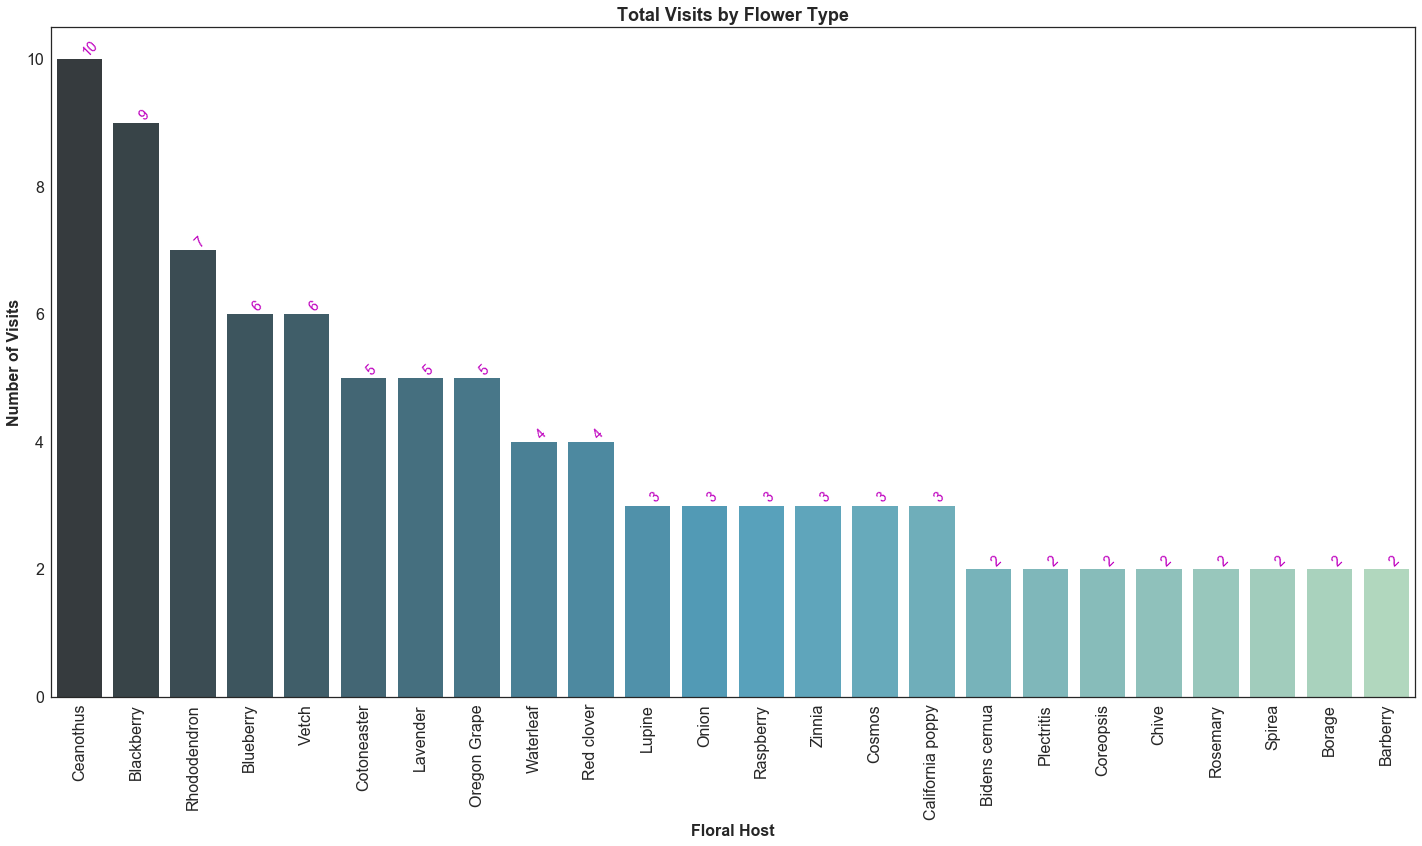

In [126]:
# Filter data to only verified sightings with a labeled floral host. Query for total abundance/count by plant species name within verified sightings
verified_sightings = bee_data[(bee_data.sightingstatus_id == 2) & bee_data['floral_host'].notnull() & bee_data['floral_host'] != 0]
print(len(verified_sightings))
numVisits = pd.DataFrame(verified_sightings.groupby(['floral_host']).size())
numVisits.columns = ['Count']
numVisits = numVisits[numVisits['Count'] > 1]
numVisits = numVisits.sort_values(['Count'], ascending=False)

# Plot barchart 
plt.figure(1, figsize=(20, 12))
ax = sns.barplot(numVisits.index, numVisits.Count, palette=sns.color_palette("GnBu_d", n_colors=24))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax.set_xlabel('Floral Host', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel('Number of Visits', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_title("Total Visits by Flower Type", fontdict={'fontsize': 18, 'fontweight':'bold'})
ax.yaxis.grid(False)

# Format axis and tick labels
lax = plt.gcf().axes[0]
lax.tick_params(labelsize=16)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(numVisits['Count'].iteritems()):
    ax.text(i, v[1], '{:,}'.format(v[1]), color='m', va='bottom', rotation=45, size=14)
plt.tight_layout()
#plt.show()
plt.savefig("VisitsByFlowerType.png")

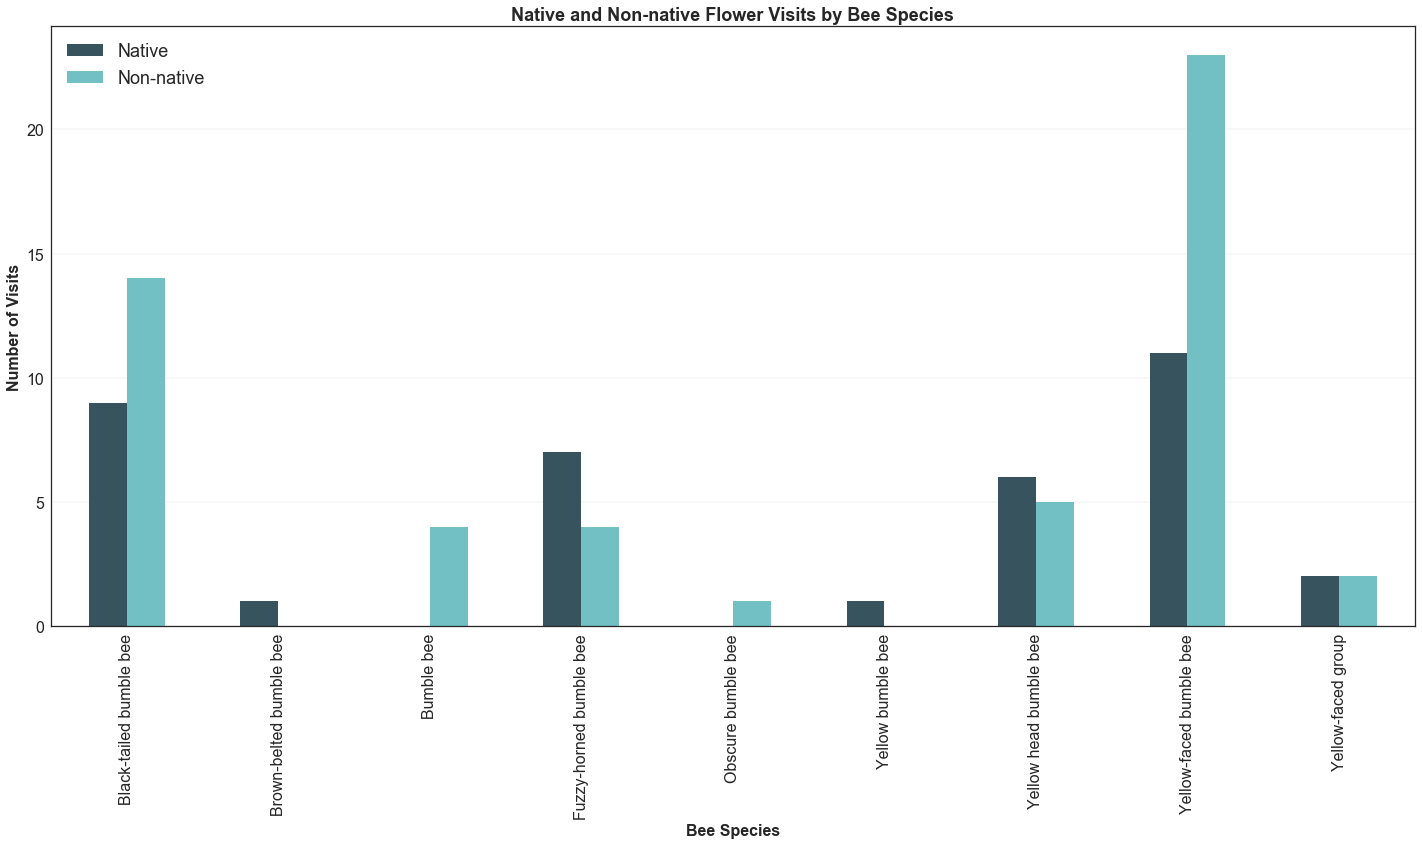

In [81]:
# Split observations into native/non-native by species
only_nativeNon_verified = verified_sightings[verified_sightings['native_status'] != 0]
nativeNon = pd.DataFrame(only_nativeNon_verified.groupby(['common_name', 'native_status']).size())
nativeNon.columns = ['Count']

unstacked = nativeNon.unstack(level=1).replace(np.nan, 0)

colormap = []
for color in sns.color_palette("GnBu_d"):
    for value in color:
        #value *= 255
        colormap.append(value)
two_color = [(float(colormap[0]), float(colormap[1]), float(colormap[2]), 1), (float(colormap[12]), float(colormap[13]), float(colormap[14]), 1)]
graph = nativeNon.unstack(level=1).plot(kind='bar', subplots=False, figsize=(20,12), color=two_color)
plt.title("Native and Non-native Flower Visits by Bee Species", fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlabel("Bee Species", fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel("Number of Visits", fontdict={'fontsize': 16, 'fontweight': 'bold'})
graph.yaxis.grid(which="major", linewidth=0.25)
lax = plt.gcf().axes[0]
lax.tick_params(labelsize=16)

plt.legend(['Native', 'Non-native'], loc='upper left', prop={'size': 18})
plt.tight_layout()
#plt.savefig("NativeNonBySpecies.png")
plt.show()

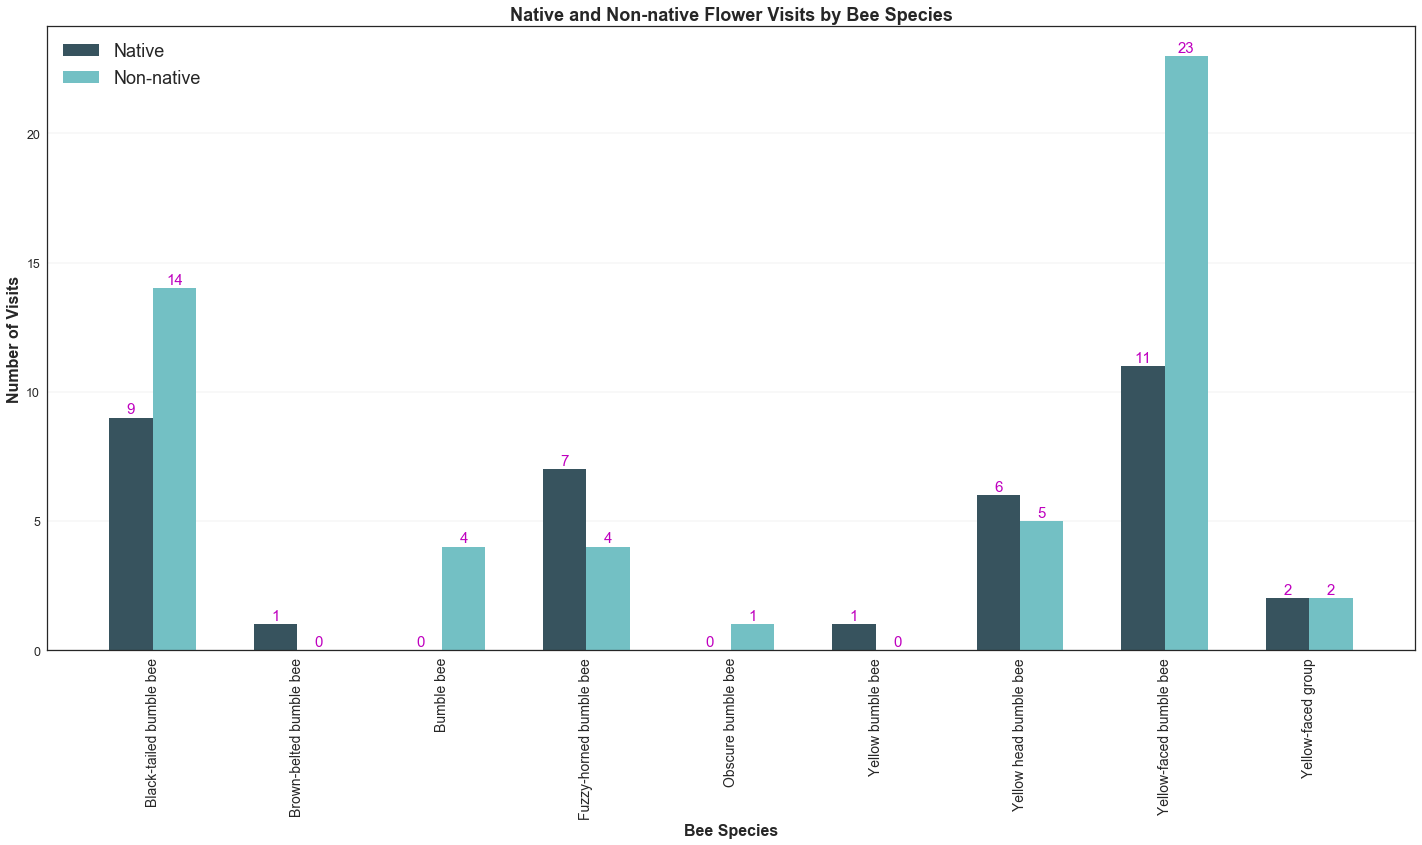

In [122]:
# Break apart above graph into two series for more annotation control. Duplicates above plot but with annotation of values
temp_df = nativeNon.reset_index()
nativeSlice = temp_df[temp_df['native_status'] == "Native"]
nonnativeSlice = temp_df[temp_df['native_status'] == "Non-native"]

color_one = two_color[0]
color_two = two_color[1]

x_tick_labels = ['Black-tailed bumble bee', 'Brown-belted bumble bee', 'Bumble bee', 'Fuzzy-horned bumble bee',
                 'Obscure bumble bee', 'Yellow bumble bee', 'Yellow head bumble bee', 'Yellow-faced bumble bee',
                 'Yellow-faced group']

native_values = (9, 1, 0, 7, 0, 1, 6, 11, 2)
nonnative_values = (14, 0, 4, 4, 1, 0, 5, 23, 2)

N = 9
 

ind = np.arange(N)  # the x locations for the groups
width = 0.30       # the width of the bars

fig, ax = plt.subplots(figsize=(20,12))
rects1 = ax.bar(ind, native_values, width, color=color_one)
rects2 = ax.bar(ind + width, nonnative_values, width, color=color_two)

# add some text for labels, title and axes ticks
ax.set_xlabel("Bee Species", fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("Number of Visits", fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_title("Native and Non-native Flower Visits by Bee Species", fontdict={'fontsize': 18, 'fontweight': 'bold'})
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(x_tick_labels, rotation=90, fontdict={'fontsize': 14})
ax.yaxis.grid(which="major", linewidth=0.25)
ax.legend((rects1[0], rects2[0]), ('Native', 'Non-native'), loc='upper left', prop={'size': 18})


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height + .05,
                '%d' % int(height),
                ha='center', va='bottom', color='m')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.savefig("NativeNonBySpecies.png")
#plt.show()

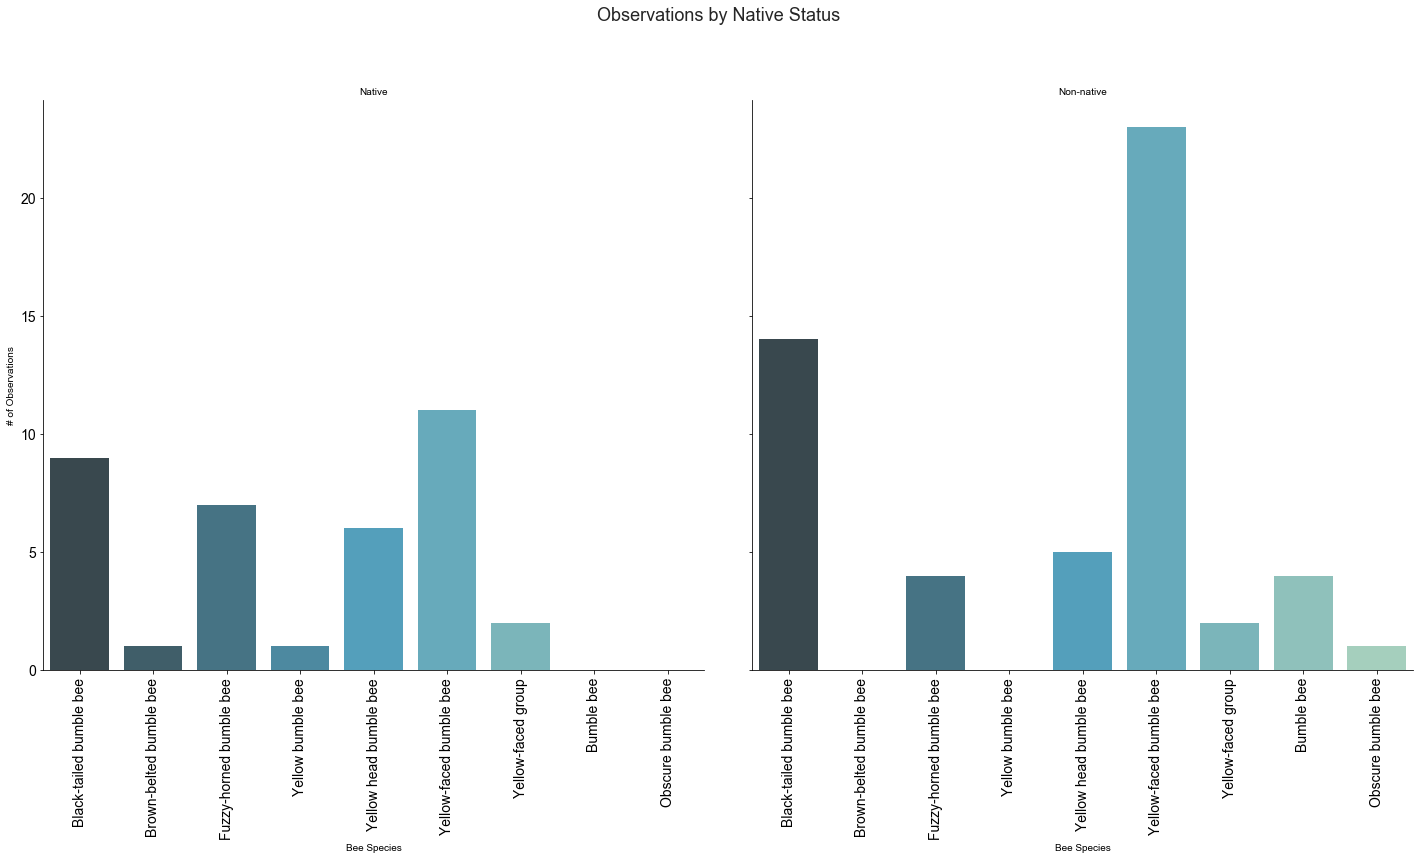

In [6]:
# Split native/non-native into separate plots by species
counts_compare = pd.DataFrame(verified_sightings.groupby(['native_status', 'common_name']).size())
counts_compare.columns = ['Count']
counts_compare = counts_compare.reset_index()
g = sns.factorplot(x="common_name", y="Count",
                    col="native_status", kind="bar", size=10, data=counts_compare, palette="GnBu_d")
(g.set_axis_labels("Bee Species", "# of Observations")
    .set_titles("{col_name}")
    .set_xticklabels(rotation=90, size=14)
    .set_yticklabels(size=14))
sns.set(font_scale=1.25)
sns.set_style('white')
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Observations by Native Status")
#plt.tight_layout()
plt.savefig("ObsByNativeStatus.png", bbox_inches='tight')

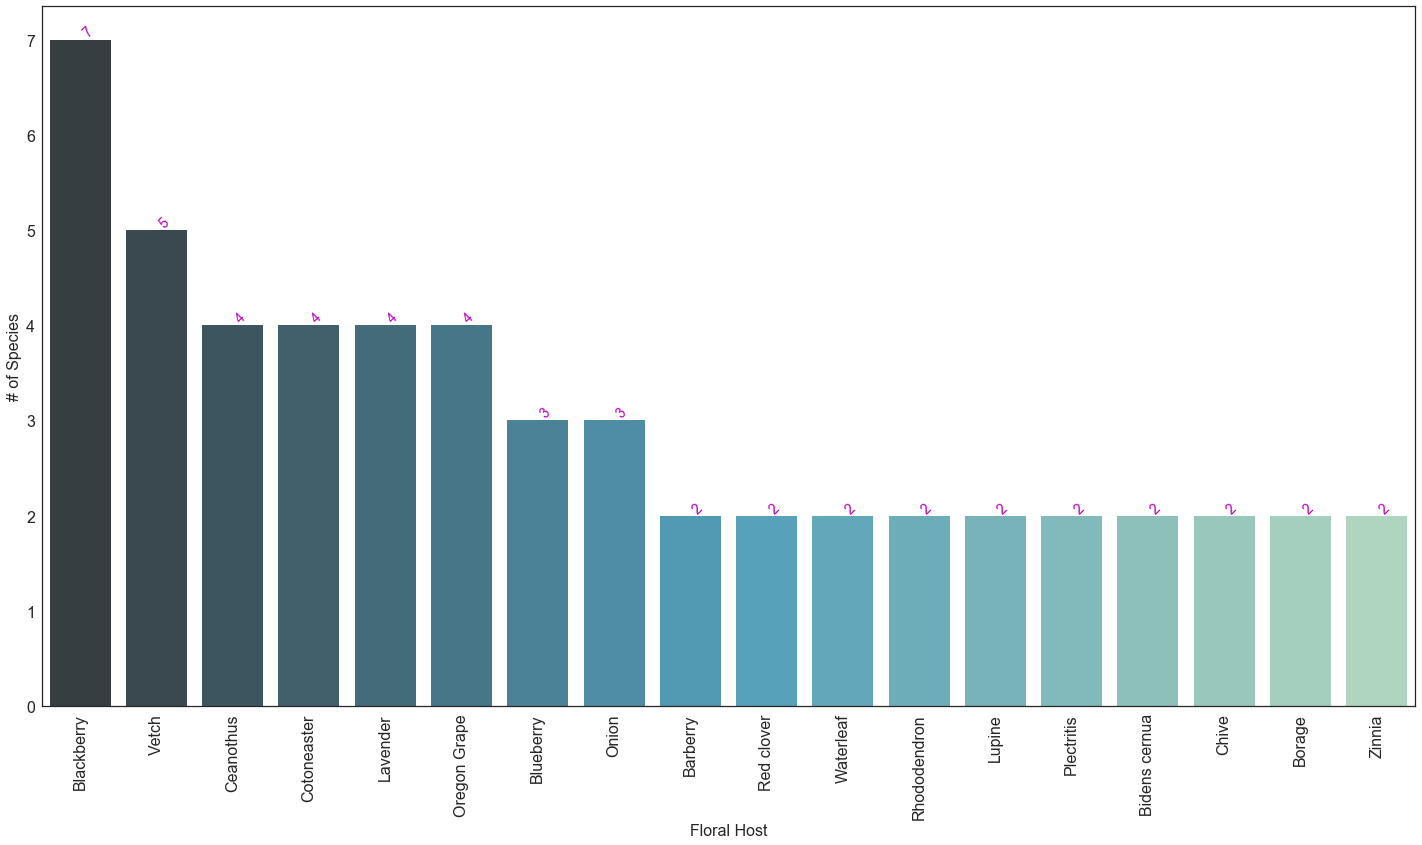

In [7]:
# Plot unique flower species visits by bee species
bee_flower = pd.DataFrame(verified_sightings.groupby(['floral_host', 'common_name']).size())
bee_flower.columns = ['Count']
bee_flower['Count'] = 1
new = pd.DataFrame(bee_flower.groupby(['floral_host']).sum())
new = new[new['Count'] > 1]
new = new.sort_values(['Count'], ascending=False)
result = new.unstack(level=1)


plt.figure(2, figsize=(20, 12))
ax2 = sns.barplot(result.index.get_level_values(1), result.Count, palette="GnBu_d")
# ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: '{:,}'.format(int(x))))
ax2.set_xlabel('Floral Host', fontsize=16)
ax2.set_ylabel('# of Species', fontsize=16)
l2ax = plt.gcf().axes[0]
l2ax.tick_params(labelsize=16)
for item in ax2.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(result['Count'].iteritems()):
    ax2.text(i, v[1], '{:,}'.format(v[1]), color='m', va='bottom', rotation=45, size=14)
plt.tight_layout()
plt.savefig("UniqueSpecies.png")
plt.show()

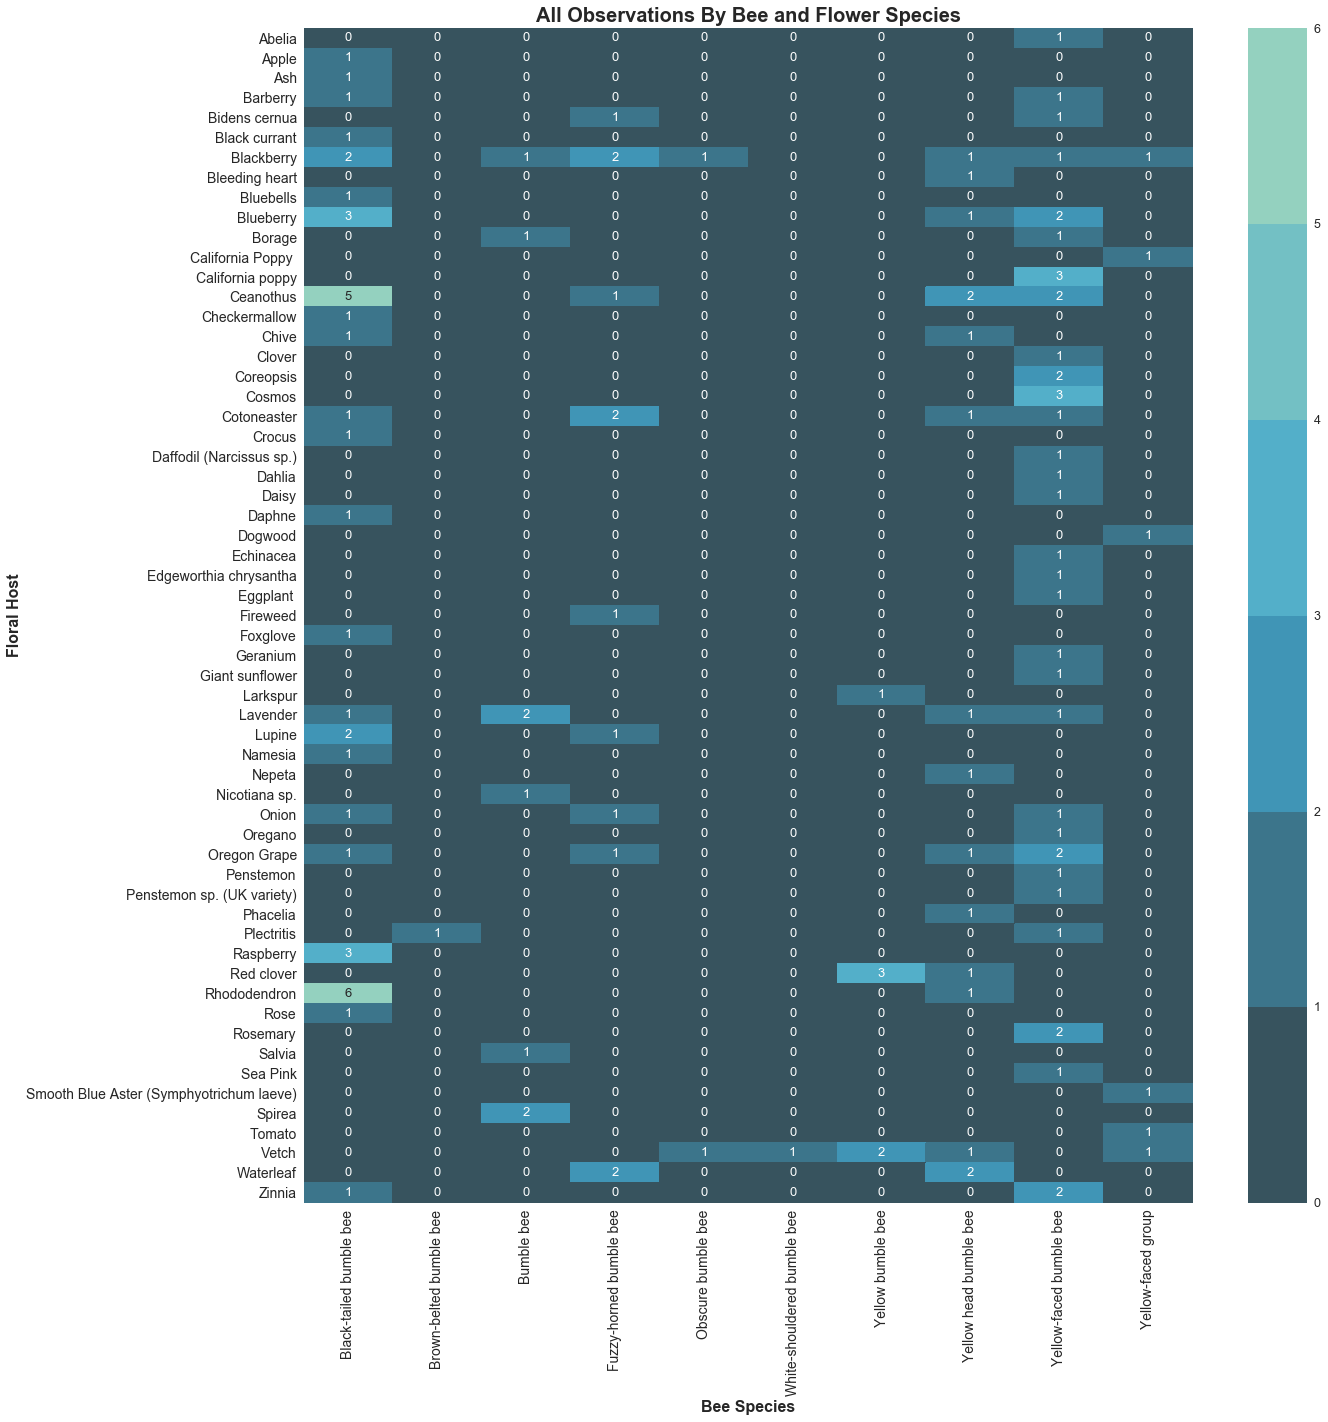

In [8]:
# Heatmap of every observation and associated bee and flower species
heatmap_df = pd.DataFrame(verified_sightings.groupby(['floral_host', 'common_name']).size())
heatmap_df.columns = ['count']
heatmap_df = heatmap_df.reset_index()
heatmap_pivot = heatmap_df.pivot("floral_host", "common_name", "count")
heatmap_pivot.fillna(0, inplace=True)
plt.figure(2, figsize=(20,20))

my_cmap = ListedColormap(sns.color_palette("GnBu_d").as_hex())
heatmap = sns.heatmap(heatmap_pivot, annot=True, cmap=my_cmap, annot_kws={"size":13})
cax = plt.gcf().axes[0]
cax.tick_params(labelsize=14)
plt.title("All Observations By Bee and Flower Species", fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.xlabel("Bee Species", fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel("Floral Host", fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.tight_layout()
plt.savefig("ObsHeatmap.png")

In [9]:
"""Generalization ratio (aka standard deviation of visit percentages) including zeros"""

# Calculate the percentage of visits each flower received by species. This normalizes data
sum_by_species = {key: value.sum() for key, value in heatmap_pivot.items()}
percentages_by_species = {}
for key, value in heatmap_pivot.items():
    percentages_by_species[key] = value / sum_by_species[key]
    
# Calculate the standard deviation of those percentages
stdev_by_species = {}
for key, value in percentages_by_species.items():
    stdev_by_species[key] = np.std(value)
print(stdev_by_species)

{'Black-tailed bumble bee': 0.030552263674475839, 'Brown-belted bumble bee': 0.1290809000993883, 'Bumble bee': 0.053765159069701363, 'Fuzzy-horned bumble bee': 0.042794512450686766, 'Obscure bumble bee': 0.09048371400026535, 'White-shouldered bumble bee': 0.12908090009938827, 'Yellow bumble bee': 0.079398131765848562, 'Yellow head bumble bee': 0.032200602020276831, 'Yellow-faced bumble bee': 0.019765938626594242, 'Yellow-faced group': 0.050374447740471777}


In [10]:
# Filter to only two bee species, convert to dataframe
stdev_df = pd.Series(stdev_by_species).sort_values(ascending=False)
stdev_df = pd.DataFrame(stdev_df.reset_index())
stdev_df.columns = ['common_name', 'std deviation']
filtered_stdev = stdev_df.loc[stdev_df['common_name'].isin(['Black-tailed bumble bee', 'Yellow-faced bumble bee'])]
filtered_stdev.index = [0,1]
filtered_stdev

,common_name,std deviation
0,Black-tailed bumble bee,0.030552
1,Yellow-faced bumble bee,0.019766


In [11]:
# Create dataframe of counts by bee species and floral host for making histograms

histos_df = heatmap_pivot.filter(['Black-tailed bumble bee', 'Yellow-faced bumble bee'])
histos_df = pd.DataFrame(histos_df.unstack()).reset_index()
histos_df
histos_df.columns = ["common_name", "floral_host", "count"]
histos_df['count'] = [int(val) for val in histos_df['count']]
non_zero_histos = histos_df[histos_df['count'] > 0]
non_zero_histos.head()

,common_name,floral_host,count
1,Black-tailed bumble bee,Apple,1
2,Black-tailed bumble bee,Ash,1
3,Black-tailed bumble bee,Barberry,1
5,Black-tailed bumble bee,Black currant,1
6,Black-tailed bumble bee,Blackberry,2


In [12]:
# Explore average visits per plant species
black_tail_avg = np.mean(histos_df[(histos_df.common_name == "Black-tailed bumble bee") & histos_df['count'] > 0]['count'])
yellow_face_avg = np.mean(histos_df[(histos_df.common_name == "Yellow-faced bumble bee") & histos_df['count'] > 0]['count'])
print("Avg. Number of Visits per plant species")
print("Black-tailed: {}".format(black_tail_avg))
print("Yellow-faced: {}".format(yellow_face_avg))

Avg. Number of Visits per plant species
Black-tailed: 1.4
Yellow-faced: 1.1666666666666667


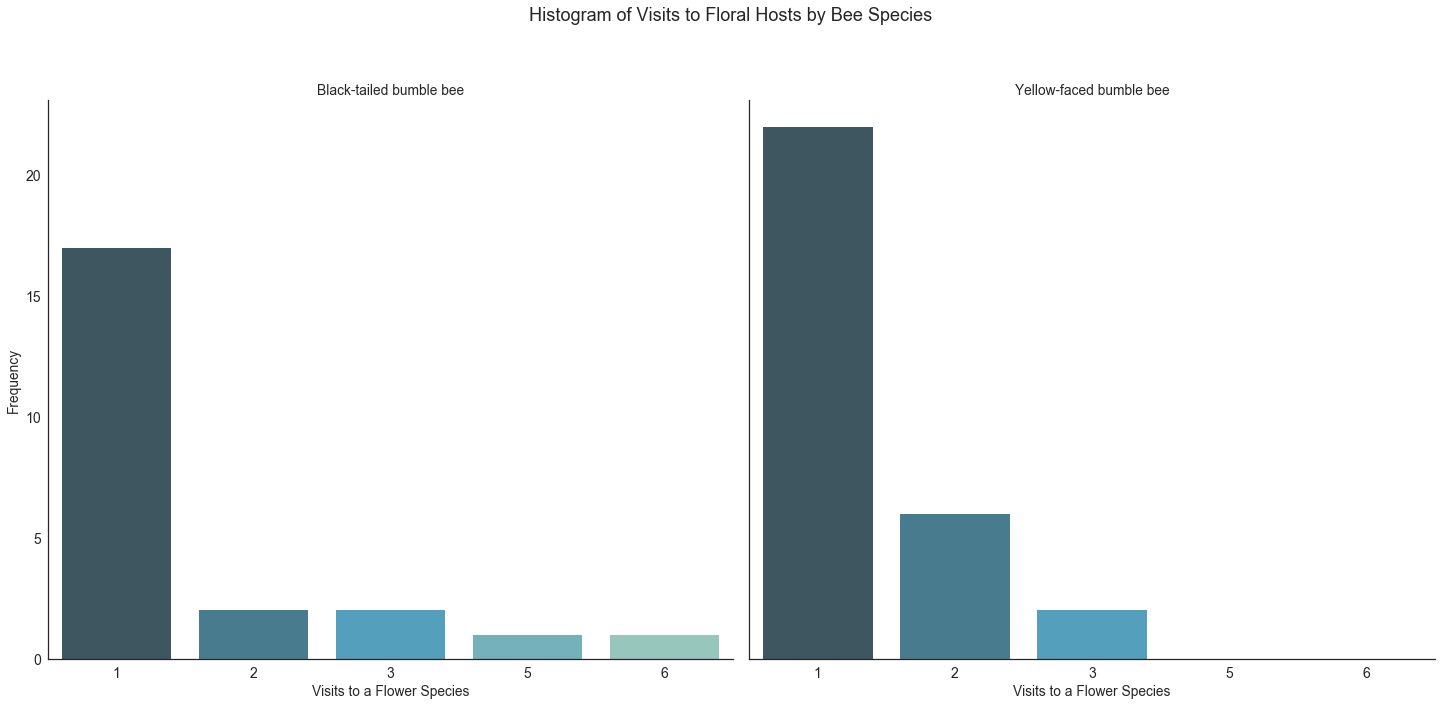

In [13]:
# Plot histogram of visits for each bee species
histos = sns.factorplot(x="count",
                    col="common_name", kind="count", size=10, data=non_zero_histos, palette="GnBu_d")

(histos.set_axis_labels("Visits to a Flower Species", "Frequency")
    .set_titles("{col_name}")
    .set_xticklabels(size=14)
    .set_yticklabels(size=14))
sns.set(font_scale=1.25)
sns.set_style('white')
plt.subplots_adjust(top=0.85)
histos.fig.suptitle("Histogram of Visits to Floral Hosts by Bee Species")
plt.savefig("Histos.png", bbox_inches="tight")

In [14]:
# manipulate dataframe so it's bee species by native/non-native. This will be our contingency table for chi-squared 
# test of independence

observed = nativeNon.unstack().transpose()
compare = observed.filter(['Black-tailed bumble bee','Yellow-faced bumble bee'], axis=1)
compare

common_name          Black-tailed bumble bee  Yellow-faced bumble bee
      native_status                                                  
Count Native                             9.0                     11.0
      Non-native                        14.0                     23.0

In [15]:
# Great link on using chi-squared in Python http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

# Calculate the chi-squared critical value
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 1)   # *

print("Critical value")
print(crit)

# Calculate the chi-squared statistic for the dataset
chi2, p, dof, expected = stats.chi2_contingency(observed=compare, correction=False)
chi2

Critical value
3.84145882069


0.27668659708301657

In [16]:
# Testing out Fisher's exact test (good when n < 5 in a given cell)
oddsratio, pvalue = stats.fisher_exact(compare)
pvalue

0.77784646022868065

In [17]:
# Fun Bayesian exploration to look at probability a plant is native given a particular bee species is observed

# Estimating probability a flower is native, given I see each species

# P(Native) = 20/57 = 35%
# P(Non-native) = 1 - 0.35 = 65%
# P(Black|Native) = 9/20  = 45%
# P(Yellow|Native) = 1 - 0.45 = 55%
# P(Black|Non-native) = 14/37 = 38%
# P(Yellow|Non-native) = 1 - 0.38 = 62%

# P(Black) = P(Native) * P(Black|Native) + P(Non-native) * P(Black|Non-native)
#          = 0.35 * 0.45 + 0.65 * 0.38 = 40.45%
# P(Yellow) = 59.55%

# P(Native|Black) = (P(Native) * P(Black|Native)) / P(Black)
#                 = 0.35 * 0.45 / 0.4045 = 38.9%
# P(Native|Yellow) = (P(Native) * P(Yellow|Native)) / P(Yellow)
#                  = 0.35 * 0.55 / 0.5955 = 32.3%

# Choosing a flowering plant/shrub at random, there's a 35% chance it's native. Seeing a Black-tailed bumblebee slightly
# slightly increases the chances, to almost 39%, whereas observing a Yellow-Faced bumblebee drops the probability it is a native
# plant to around 32%. 


In [18]:
# Total Native plant observations where sighting status verified
len(verified_sightings.loc[verified_sightings['native_status'] == 'Native'])

37

In [19]:
# Total non-native plant observations where sighting status verified
len(verified_sightings.loc[verified_sightings['native_status'] == 'Non-native'])

53